<a href="https://colab.research.google.com/github/faisu6339-glitch/ML-Projects-/blob/main/P_9_Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import accuracy_score

In [85]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [86]:
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

#Data Pre-Processing

In [87]:
df = pd.read_csv('fake_news1.csv')

In [88]:
df.head()

,title,text,subject,date,label,text_length
0,Stock market shows positive growth,Officials announced a new initiative to improv...,health,2023-08-26,0,77
1,International leaders hold meeting,Officials announced a new initiative to improv...,world,2023-02-01,0,77
2,Earth will stop rotating tonight,This viral claim is spreading online without a...,entertainment,2023-01-09,1,88
3,Government to ban internet next month,This viral claim is spreading online without a...,entertainment,2023-11-10,1,88
4,Earth will stop rotating tonight,This viral claim is spreading online without a...,world,2023-02-12,1,88


In [89]:
df.columns

Index(['title', 'text', 'subject', 'date', 'label', 'text_length'], dtype='object')

In [90]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786 entries, 0 to 785
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        723 non-null    object
 1   text         723 non-null    object
 2   subject      723 non-null    object
 3   date         786 non-null    object
 4   label        786 non-null    int64 
 5   text_length  786 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 37.0+ KB


In [91]:
df.isnull().sum()

,0
title,63
text,63
subject,63
date,0
label,0
text_length,0


In [92]:
df.duplicated().sum()

np.int64(11)

#As there are missing values more than 5% and all these columns are categorical so i will use fillna method

In [93]:
# Title (text)
df['title'].fillna("No Title", inplace=True)

# Text (main content)
df['text'].fillna("", inplace=True)

# Subject (categorical)
df['subject'].fillna(df['subject'].mode()[0], inplace=True)

# Check
print(df.isnull().sum())


title          0
text           0
subject        0
date           0
label          0
text_length    0
dtype: int64


/tmp/ipython-input-1860603815.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['title'].fillna("No Title", inplace=True)
/tmp/ipython-input-1860603815.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [94]:
df.shape

(786, 6)

# Outliers

In [95]:
Q1=df['text_length'].quantile(0.25)
Q3=df['text_length'].quantile(0.75)
IQR=Q3-Q1
lower_limit=Q1-1.5*IQR
upper_limit=Q3+1.5*IQR

outliers=df[(df['text_length']<lower_limit) | (df['text_length']>upper_limit)]
outliers[['title','text_length']].head()

,title,text_length
7,Aliens sign agreement with world leaders,4
15,Stock market shows positive growth,4
31,Secret pill cures all diseases instantly,4
40,Government launches new policy,9992
42,No Title,4


#For all the outliers detection


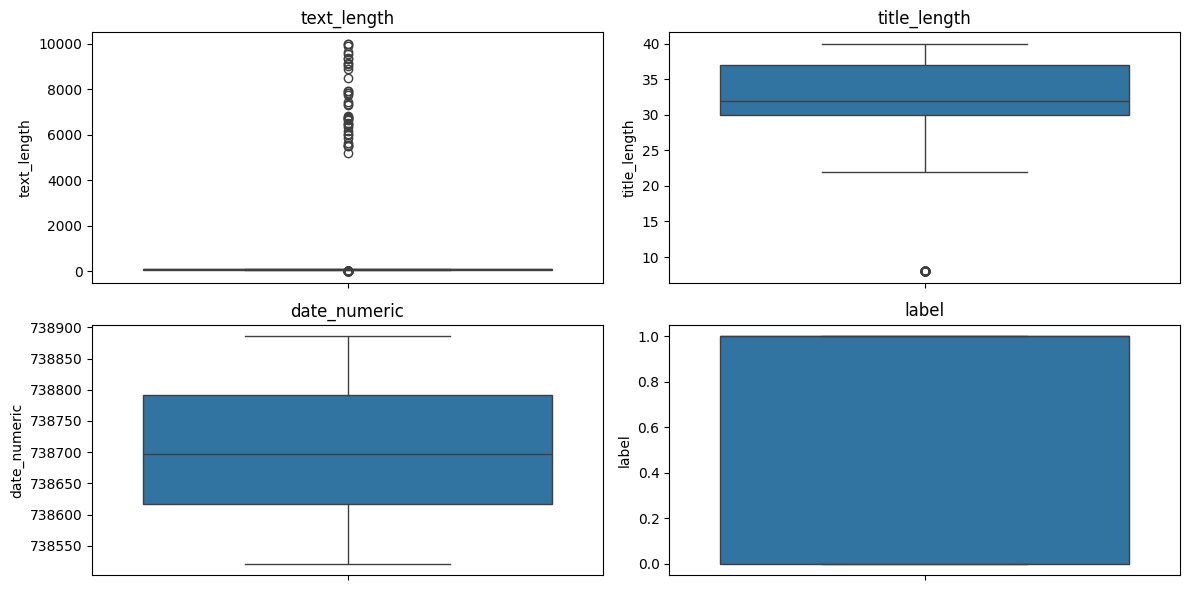

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Copy dataset
data = df.copy()

# Create numeric features
data['title_length'] = data['title'].astype(str).str.len()

# Convert date to datetime then numeric
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data['date_numeric'] = data['date'].map(pd.Timestamp.toordinal)

# Select numeric columns only
numeric_cols = ['text_length', 'title_length', 'date_numeric', 'label']

# ---------- Boxplots ----------
plt.figure(figsize=(12,6))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=data[col])
    plt.title(col)

plt.tight_layout()
plt.show()


In [112]:
def detect_outliers_iqr(data, column):
    # Calculate Q1, Q3 and IQR
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Limits
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Outliers
    outliers = data[(data[column] < lower_limit) | (data[column] > upper_limit)]

    print(f"\nColumn: {column}")
    print(f"Lower limit: {lower_limit}")
    print(f"Upper limit: {upper_limit}")
    print(f"Total outliers: {outliers.shape[0]}")

    return outliers


In [113]:
columns = ['text_length']   # you can add more columns here

for col in columns:
    outliers = detect_outliers_iqr(df, col)
    print(outliers[['title', col]].head())



Column: text_length
Lower limit: 60.5
Upper limit: 104.5
Total outliers: 0
Empty DataFrame
Columns: [title, text_length]
Index: []


In [115]:
columns = ['text_length', 'title_length']

for col in columns:
    outliers = detect_outliers_iqr(df, col)
    print(outliers[[col]].head())


Column: text_length
Lower limit: 60.5
Upper limit: 104.5
Total outliers: 0
Empty DataFrame
Columns: [text_length]
Index: []

Column: title_length
Lower limit: 24.5
Upper limit: 44.5
Total outliers: 38
     title_length
18             22
25             22
34             22
73             22
105            22


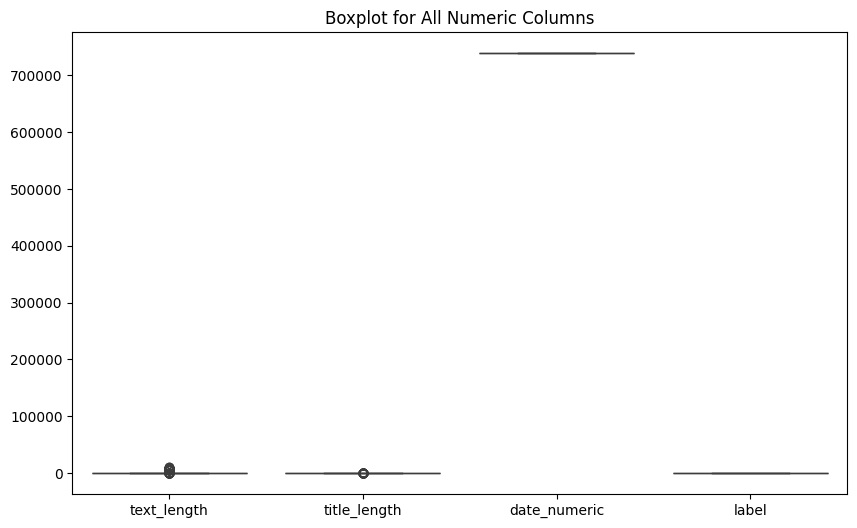

In [97]:
plt.figure(figsize=(10,6))
sns.boxplot(data=data[numeric_cols])
plt.title("Boxplot for All Numeric Columns")
plt.show()


In [98]:
import pandas as pd

# ---------- Step 1: Create required columns ----------
df['title_length'] = df['title'].astype(str).str.len()

# Convert date
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Remove invalid dates first
df = df.dropna(subset=['date'])

# Convert date to numeric
df['date_numeric'] = df['date'].map(pd.Timestamp.toordinal)

print("Before removing outliers:", df.shape)


Before removing outliers: (786, 8)


In [99]:
df.shape


(786, 8)

In [100]:
cols = ['text_length', 'title_length', 'date_numeric']

for col in cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df = df[(df[col] >= lower) & (df[col] <= upper)]

print("After removing outliers:", df.shape)


After removing outliers: (630, 8)


In [101]:
df.shape


(630, 8)

In [104]:
df.columns


Index(['title', 'text', 'subject', 'date', 'label', 'text_length',
       'title_length', 'date_numeric'],
      dtype='object')

In [103]:
df['label'].value_counts()


,count
label,
1,325
0,305


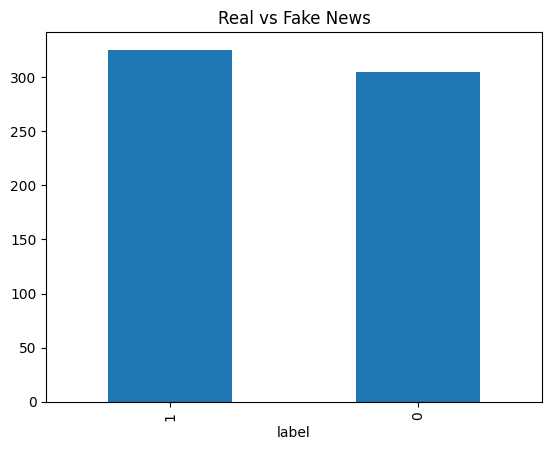

In [106]:
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar')
plt.title("Real vs Fake News")
plt.show()


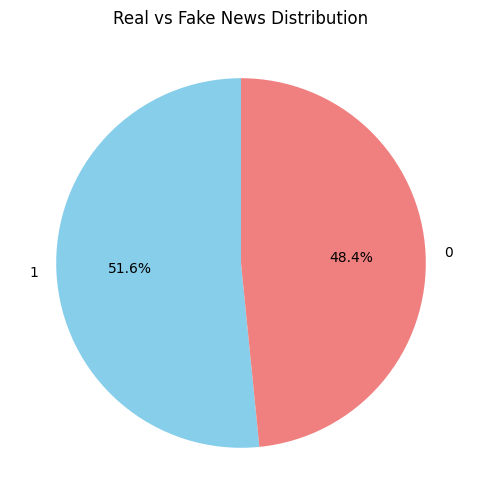

In [107]:
import matplotlib.pyplot as plt

# Count values
counts = df['label'].value_counts()

# Pie chart
plt.figure(figsize=(6,6))
counts.plot(
    kind='pie',
    autopct='%1.1f%%',   # show percentage
    startangle=90,       # rotate for better view
    colors=['skyblue', 'lightcoral']
)

plt.title("Real vs Fake News Distribution")
plt.ylabel("")   # removes 'label' text on side
plt.show()


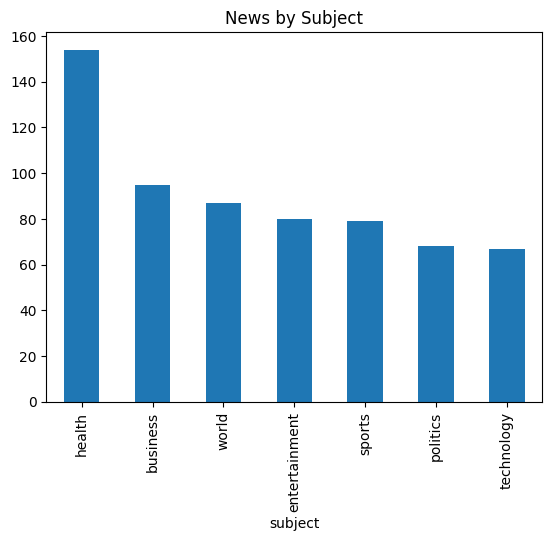

In [109]:
df['subject'].value_counts().plot(kind='bar')
plt.title("News by Subject")
plt.show()


In [111]:
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

df['content'] = df['title'] + ' ' + df['text']
df['content'] = df['content'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['content'])
y = df['label']


In [118]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [119]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [123]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        67

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126

[[59  0]
 [ 0 67]]


In [121]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        67

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126

[[59  0]
 [ 0 67]]


In [122]:
def predict_news(text):
    text = clean_text(text)
    vec = tfidf.transform([text])
    pred = model.predict(vec)
    return "Fake" if pred[0]==1 else "Real"

predict_news("Breaking: Government announces new policy today")


'Real'

In [124]:
import pickle

pickle.dump(model, open("fake_news_model.pkl", "wb"))
pickle.dump(tfidf, open("tfidf.pkl", "wb"))


In [125]:
def predict_news(news):
    news = clean_text(news)
    vec = tfidf.transform([news])
    pred = model.predict(vec)
    return "Fake" if pred[0]==1 else "Real"


In [126]:
predict_news("Government announces free electricity for all")


'Fake'